# Getting started: running the subpocket-based docking pipeline

In this tutorial, we will demonstrate how to run the subpocket-based docking pipeline in a small example. Specifically, we will:
1. configure and discuss the program parameters, 
2. execute the subpocket-based docking pipeline, and
3. inspect the resulting output files.

**Note:** In the notebook [getting_started.ipynb](getting_started.ipynb), we demonstrated, how to prepare the protein structure and specifically how generate the FlexX and Hydescorer configuration files. These files will be assumed to be given in this tutorial. 

In [26]:
# imports
import json
import pprint
import os

from pathlib import Path

from src.evaluation.utils import pplistdir, read_mols
from rdkit.Chem import PandasTools
from rdkit.Chem.Draw import IPythonConsole
from IPython.display import HTML

In [27]:
IPythonConsole.ipython_useSVG = True
PandasTools.RenderImagesInAllDataFrames(images=True)

In [28]:
# paths
HERE = Path(".")
ROOT = HERE / ".."
PATH_TEMPLATE_SETTINGS = ROOT / "config" / "templates" / "settings.json"

## Program configuration
All program specific parameters can be adjusted in JSON files is passed to the program later. To set up such a file, we start with the template file [config/template/settings.json](../config/templates/settings.json):

In [29]:
# Read template config file
with open(PATH_TEMPLATE_SETTINGS, 'r') as file:
    config = json.load(file)

# For readability reasons, we use pprint instead of the native printing here
pprint.pp(config)

{'Name': 'TODO',
 'CoreSubpocket': 'TODO',
 'Subpockets': ['TODO', '...'],
 'KinFragLib': 'TODO',
 'Config': 'TODO',
 'FlexX': 'TODO',
 'Hyde': 'TODO',
 'NumberFragmentsPerIterations': 100,
 'NumberPosesPerFragment': 5,
 'Filters': {'pains': {},
             'brenk': {'path_data': 'KinFragLib/data/filters/Brenk'},
             'ro3': {},
             'qed': {'cutoff_val': 0.492},
             'syba': {'cutoff_val': 0}},
 'UseClusterBasedPoseFiltering': True,
 'DistanceThresholdClustering': 1.5,
 'NumberThreads': 1,
 'Seed': 42,
 'UseClusterBasedFragmentFiltering': True,
 'PSoftMin': 1,
 'UseHyde': True,
 'HydeDisplacementCutoff': 2.5}


Here, we see all program parameters that can/need to be adjusted. Some of the parameters are set to `TODO` implying that these need to be adjusted, and thus are required. The other options are not necessarily required, here they are set to their default values. In the following, we will first set the required parameters and then discuss the optional parameters.

### Required program parameters
First, we set the project name (`Name`). The project name will be used by the program to infer the `.flexx` and `.hydescorer` configuration files, as well as, to name the output folder. 

First, we define the paths to:


In [30]:
PROJECT_NAME = '5n1f_tut'
config['Name'] = PROJECT_NAME

Next, we define the core subpocket and subpocket path. As we want to start growing the ligands from the AP subpocket, into the FP, we define the core subpocket (`CoreSubpocket`) and subpocket path (`subpockets`) accordingly. 

**Note:** here, we are only growing into one subpocket - the FP subpocket -, however one can also grow into more subpockets by adding them to the subpocket list.

In [31]:
config['CoreSubpocket'] = 'AP'
config['Subpockets'] = ['FP']

Lastly, we need to define the paths to:
* the `Config` folder, where the `.flexx` and `.hydescorer` files are located,
* the `FlexX` and `Hyde` executable (can be downloaded from the [BiosolveIT website](https://www.biosolveit.de/download/)),
* and the fragment library of [`KinFragLib`](https://github.com/volkamerlab/KinFragLib/tree/master),
* and, - since we apply here some custom kinfraglib filters, also the path to the Brenk collection

**Note:** These paths - especially `FlexX` and `Hyde` - may need to be adjusted depending where they have been placed and on the machine that is used. Further, one might need to adjust the path to the `brenk` collection. However, we won't apply this filter in this tutorial, thus adapting this is not needed here.

**Note:** in this example, we use a highly reduced version of the KinFragLib fragments library that was designed only for this tutorial ([`fragment_library_tiny`](fragment_library_tiny)). It only comprises 12 fragments that are only assigned to the subpockets AP and FP. In a real-world application, one would preferably use the libraries from [`KinFragLib`](https://github.com/volkamerlab/KinFragLib/tree/master/data).

In [ ]:
# define paths
config['Config'] = '../config'
config['FlexX'] = '../flexx-6.3.1-Linux-x64/flexx'
config['Hyde'] = '../hydescorer-2.3.1-Linux-x64/hydescorer'
config['KinFragLib'] = 'fragment_library_tiny'

# the brenk collection could be linked here if needed:
# config['Filters']['brenk']['path_data'] = '../KinFragLib/data/filters/Brenk'

pprint.pp(config)

{'Name': '5n1f_tut',
 'CoreSubpocket': 'AP',
 'Subpockets': ['FP'],
 'KinFragLib': '../KinFragLib/data/fragment_library_tiny',
 'Config': '../config',
 'FlexX': '../flexx-6.3.1-Linux-x64/flexx',
 'Hyde': '../hydescorer-2.3.1-Linux-x64/hydescorer',
 'NumberFragmentsPerIterations': 100,
 'NumberPosesPerFragment': 5,
 'Filters': {'pains': {},
             'brenk': {'path_data': 'KinFragLib/data/filters/Brenk'},
             'ro3': {},
             'qed': {'cutoff_val': 0.492},
             'syba': {'cutoff_val': 0}},
 'UseClusterBasedPoseFiltering': True,
 'DistanceThresholdClustering': 1.5,
 'NumberThreads': 1,
 'Seed': 42,
 'UseClusterBasedFragmentFiltering': True,
 'PSoftMin': 1,
 'UseHyde': True,
 'HydeDisplacementCutoff': 2.5}


Now, all required arguments are set. Let's briefly discuss the other parameters that can be adjusted.

### Optional program parameters
#### Fragment library reduction
- `Filters` - defines Custom KinFragLib filters that are applied to the given fragment library, available filters are: `pains`, `brenk`, `ro3`, `qed`, `bb`, `syba` (for more information on the filters, refer to TODO).

In this tutorial, we will only apply the `ro3` filter with its default parameters:

In [33]:
config['Filters'] = {'ro3' : {}}

#### HYDE scoring and optimization
* `UseHyde`- if `True`, HYDE (cite) is performed after FlexX docking. This is performed by default.
* `HydeDisplacementCutoff` - sometimes, HYDE marginally displaces the docking poses which can move the fragments outside their respective subpockets and might imply an unfavorable docking poses. Poses that derivate more than this cutoff, are discarded.  

#### Candidate filtering (per subpocket iteration)
- `NumberFragmentsPerIterations` - specifies the number of candidates - i.e. fragments or fragments combinations - that is selected in each subpocket iteration.
- `UseClusterBasedFragmentFiltering` - if `True`, a cluster based strategy is used to select a more diverse (regarding the Tanimoto similarity of molecular fingerprints) set of promising candidates. Otherwise, the `NumberFragmentsPerIterations` best scoring candidates are chosen.
- `PSoftMin` - variable that is used within the cluster-based selection strategy (`UseClusterBasedFragmentFiltering`). Informally, this number let's use adjust, whether we focus more on the diversity or the score during the candidate selection. A higher value, leads to a more randomized selection of clusters and thus a higher diversity. Thus, it becomes more likely that compounds with an unfavorable score are selected the higher the variable.

As a toy example, we will select only 10 candidates per subpocket iteration and employ the cluster-based selection strategy with default parameters:

In [34]:
config['NumberFragmentsPerIterations'] = 4

#### Pose selection (per subpocket iteration)
- `NumberPosesPerFragment` - defines the number of docking poses that is selected **per** candidates and that are then used as template conformation for the growing process.
- `UseClusterBasedPoseFiltering` - if `True`, a cluster based strategy is used to select a more diverse (regarding the RMSD of the atom positions) set of high scoring docking poses. Otherwise, the `NumberPosesPerFragment` best scoring poses are chosen.
- `DistanceThresholdClustering` - defines the maximum distance that poses can have in one cluster. Since only one pose is selected per cluster, a high value would lead that more dissimilar compounds are considered as similar. If `DistanceThresholdClustering` is chosen very close to 0, it's similar to simply selecting the `NumberPosesPerFragment` best scoring poses.

Here, we will select only 2 candidates per subpocket iteration and employ the cluster-based selection strategy with default parameters:

In [35]:
config['NumberPosesPerFragment'] = 2

#### Threads and seed
- `Seed` - seed to use
- `Threads` - number of threads

In [36]:
config['Threads'] = 16

### Saving the settings file
As a last step before running the subpocket-based docking pipeline, we will save the config as a JSON such that we can pass it to the pipeline next:

In [37]:
# pathsname
CONFIG_FOLDER = ROOT / "config" / PROJECT_NAME
PATH_TUTORIAL_SETTINGS = CONFIG_FOLDER / "settings.json"

In [38]:
with open(PATH_TUTORIAL_SETTINGS, 'w') as file:
    json.dump(config, file)

## Run the pipeline
With the `-h` option, we can see the help page, inspecting all available command line arguments:

In [39]:
pipeline_prefix = 'python ' + str(ROOT / 'src/fragment_docking.py')

In [40]:
_r = os.system(pipeline_prefix + ' -h')

usage: ../src/fragment_docking.py [-h] [-s SETTINGS] [-r RESULTS]
                                  [-log LOGLEVEL]

Generates compounds for a given kinase

optional arguments:
  -h, --help            show this help message and exit
  -s SETTINGS, --settings SETTINGS
                        JSON file with program configuration
  -r RESULTS, --results RESULTS
                        Folder, where results are placed
  -log LOGLEVEL, --loglevel LOGLEVEL
                        Logging level (error, warning, info, or debug).
                        Example --loglevel debug, default=info


We need to define a folder where all resulting files are placed. Thus, if not already present, we create such a `result` folder:

In [41]:
RESULTS_FOLDER = ROOT / "results"

In [42]:
if not os.path.exists(RESULTS_FOLDER):
    os.makedirs(RESULTS_FOLDER)

Let's finally run the subpocket-based docking pipeline on the prepared PKA target:

In [43]:
# full command
cmd = pipeline_prefix + ' -s ' + str(PATH_TUTORIAL_SETTINGS) + ' -r ' + str(RESULTS_FOLDER)
cmd

'python ../src/fragment_docking.py -s ../config/5n1f_tut/settings.json -r ../results'

In [44]:
# this might take a while (~5 minutes)
_r = os.system(cmd)

wandb: Currently logged in as: kabu00002 (kinase_pocket_enum) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.19.11
wandb: Run data is saved locally in /home/katharina/KinFragLib_PocketEnum/notebooks/wandb/run-20250625_153825-19c6jprp
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run 5n1f_tut
wandb: ⭐️ View project at https://wandb.ai/kinase_pocket_enum/subpocket_based_docking_kinases
wandb: 🚀 View run at https://wandb.ai/kinase_pocket_enum/subpocket_based_docking_kinases/runs/19c6jprp
2025-06-25 15:38:26 - INFO - Preprocessing started
2025-06-25 15:38:26 - INFO - Preprocessing finished
2025-06-25 15:38:26 - INFO - Size of fragment library{'AP': 6, 'FP': 5}
2025-06-25 15:38:26 - INFO - Core docking of 6 AP-Fragments
2025-06-25 15:40:26 - INFO - Runtime: 120.12083053588867
2025-06-25 15:40:26 - INFO - Template docking of 5 FP-Fragments
2025-06-25 15:40:26 - INFO - Created 5 clusters
2025-06-25 15:40:26 - INF

wandb: 
wandb: 🚀 View run 5n1f_tut at: https://wandb.ai/kinase_pocket_enum/subpocket_based_docking_kinases/runs/19c6jprp
wandb: Find logs at: wandb/run-20250625_153825-19c6jprp/logs


**Note:** since we use a **highly** reduced fragment library, this *only* takes about 5 minutes. However, on a larger library - depending on the number of fragments to choose per iteration - this would take hours to few days. Thus, running the pipeline on a cluster might be a good idea.

## Resulting files
In the end, let's briefly discuss the output of the pipeline:

In [45]:
pplistdir(RESULTS_FOLDER)

 - results
 |	 - 5n1f_tut
 |	 |	 - FP_filtering_stats.json
 |	 |	 - SP0.sdf
 |	 |	 - SP1.sdf
 |	 |	 - program_statistics.json
 |	 |	 - results.sdf
 |	 |	 - violations_SP0.sdf
 |	 |	 - violations_SP1.sdf


### Program statistics
`program_statistics.json` - contains several numbers such as the number of docked molecules that were produced during the program run as well as the program configuration:

In [46]:
with open(RESULTS_FOLDER / PROJECT_NAME / "program_statistics.json", 'r') as file:
    program_stats = json.load(file)

# For readability reasons, we use pprint instead of the native printing here
pprint.pp(program_stats)

{'StartingTime': '2025-06-25 15:38:26',
 'pdbCode': '5n1f_tut',
 'CoreSubpocket': 'AP',
 'Subpockets': ['FP'],
 'UsedHyde': True,
 'HydeDisplacementCutoff': 2.5,
 'NumberPosesPerFragment': 2,
 'NumberFragmentsPerIterations': 4,
 'UseClusterBasedPoseFiltering': True,
 'DistanceThresholdClustering': 2.5,
 'Filters': ['ro3'],
 'GeneratedPoses': {'SP0': 20, 'SP1': 73},
 'ChosenPoses': {'SP0': 7},
 'ChosenMolecules': {'SP0': 4},
 'UndockableMolecules': {'SP0': 1, 'SP1': 11},
 'Recombinations': {'SP1': 20},
 'RunTimeTotal': '00:05:04',
 'RunTimeCoreDocking': '00:02:00',
 'RunTimeTemplateDocking': {'SP1': '00:03:04'},
 'DockedMolecules': {'SP0': 5, 'SP1': 9},
 'MeanHydeDisplacement': {'SP0': 2.166745232556398, 'SP1': 2.060710105561893},
 'MeanHydeDisplacementIncludingViolations': {'SP0': 2.3910557873824283,
                                             'SP1': 2.2645646109822133},
 'NumDisplacementViolations': {'SP0': 12, 'SP1': 11},
 'DockingRuns': {'SP0': 6, 'SP1': 35},
 'SuccesfullDockingRun

### Generated molecules
`results.sdf` - this can be considered as the *real* output of the pipeline, it comprises the highest scoring docking pose of each docked molecule per subpocket iteration that comprise at least 2 fragments


To see examples on how one can access the resulting molecules, please refer to the following notebooks:
* [Chemical Property Evaluation](evaluate_chemical_properties.ipynb)
* [Diversity](diversity.ipynb)
* [Novelty](novelty.ipynb)

,ROMol,binding_affinity,docking_score,num_fragments,inchi,AP_smiles,FP_smiles,AP_smiles_dummy,FP_smiles_dummy,AP,FP
0,,8.621883e+01,56.20,2,"InChI=1S/C16H14ClN7/c1-24-12(8-18-10-5-3-2-4-6-10)22-23-16(24)13-11(17)7-19-15-14(13)20-9-21-15/h2-7,9,18H,8H2,1H3,(H,19,20,21)",[14*]c1c(Cl)cnc2nc([24*])[nH]c12,Cn1cnnc1CNc1ccccc1,Clc1cnc2nc[nH]c2c1,*c1nnc(CNc2cccc([34*])c2)n1C,1,2
1,,1.248054e+03,-9.45,2,"InChI=1S/C18H16ClN3O2/c19-16-10-15-12(6-8-21-18(15)24)9-13(16)4-5-17(23)22-11-14-3-1-2-7-20-14/h1-3,6-10H,4-5,11H2,(H,21,24)(H,22,23)",[17*]c1cc2cc[nH]c(=O)c2cc1Cl,CCC(=O)NCc1ccccn1,O=c1[nH]ccc2ccc(Cl)cc12,[20*]CCC(=O)NCc1ccccn1,2,3
2,,3.215811e+03,118.75,2,"InChI=1S/C23H30N2O2/c1-22(2,3)18-6-4-17(5-7-18)15-23(24)10-12-25(13-11-23)19-8-9-20-21(14-19)27-16-26-20/h4-9,14H,10-13,15-16,24H2,1-3H3",[65*]c1ccc2c(c1)OCO2,CC(C)(C)c1ccc(CC2([NH3+])CCNCC2)cc1,c1ccc2c(c1)OCO2,[44*]N1CCC([NH3+])(Cc2ccc(C(C)(C)C)cc2)CC1,3,4
3,,4.502623e+03,-12.05,2,"InChI=1S/C14H12ClN3OS/c1-7(2)13-17-18-14(20-13)10-5-8-3-4-16-12(19)9(8)6-11(10)15/h3-7H,1-2H3,(H,16,19)",[17*]c1cc2cc[nH]c(=O)c2cc1Cl,CC(C)c1nncs1,O=c1[nH]ccc2ccc(Cl)cc12,[18*]c1nnc(C(C)C)s1,2,0
4,,8.642948e+03,52.51,2,"InChI=1S/C11H10ClN5S/c1-5(2)10-16-17-11(18-10)7-6(12)3-13-9-8(7)14-4-15-9/h3-5H,1-2H3,(H,13,14,15)",[14*]c1c(Cl)cnc2nc([24*])[nH]c12,CC(C)c1nncs1,Clc1cnc2nc[nH]c2c1,[18*]c1nnc(C(C)C)s1,1,0
5,,1.536492e+04,24.22,2,"InChI=1S/C15H14ClN5O/c16-12-8-19-15-14(20-9-21-15)11(12)4-5-13(22)18-7-10-3-1-2-6-17-10/h1-3,6,8-9H,4-5,7H2,(H,18,22)(H,19,20,21)",[14*]c1c(Cl)cnc2nc([24*])[nH]c12,CCC(=O)NCc1ccccn1,Clc1cnc2nc[nH]c2c1,[20*]CCC(=O)NCc1ccccn1,1,3
6,,8.365249e+04,-7.18,2,"InChI=1S/C17H17N7/c1-11-8-19-16-14(11)15(20-10-21-16)17-23-22-13(24(17)2)9-18-12-6-4-3-5-7-12/h3-8,10,18H,9H2,1-2H3,(H,19,20,21)",[8*]c1ncnc2[nH]cc(C)c12,Cn1cnnc1CNc1ccccc1,Cc1c[nH]c2ncncc12,*c1nnc(CNc2cccc([34*])c2)n1C,4,2
7,,4.885075e+05,-13.21,2,"InChI=1S/C19H16ClN5O/c1-25-17(11-22-13-5-3-2-4-6-13)23-24-18(25)15-9-12-7-8-21-19(26)14(12)10-16(15)20/h2-10,22H,11H2,1H3,(H,21,26)",[17*]c1cc2cc[nH]c(=O)c2cc1Cl,Cn1cnnc1CNc1ccccc1,O=c1[nH]ccc2ccc(Cl)cc12,*c1nnc(CNc2cccc([34*])c2)n1C,2,2
8,,1.510686e+06,21.03,2,"InChI=1S/C17H16N4O2/c1-21-16(10-18-13-5-3-2-4-6-13)19-20-17(21)12-7-8-14-15(9-12)23-11-22-14/h2-9,18H,10-11H2,1H3",[65*]c1ccc2c(c1)OCO2,Cn1cnnc1CNc1ccccc1,c1ccc2c(c1)OCO2,*c1nnc(CNc2cccc([34*])c2)n1C,3,2

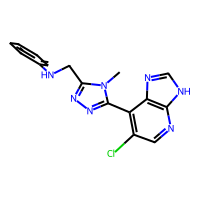
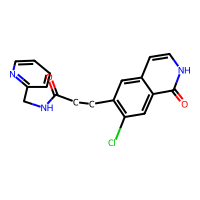
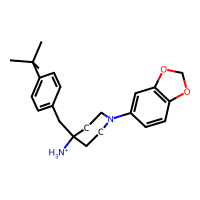
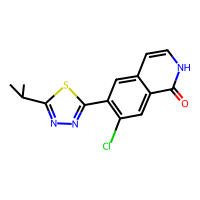
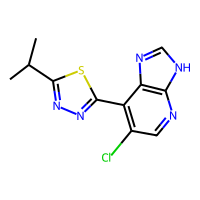
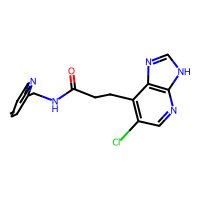
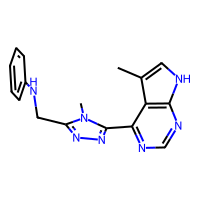
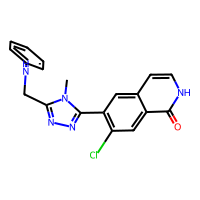
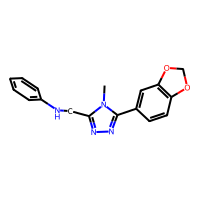

In [47]:
generated_molecules = read_mols(RESULTS_FOLDER / PROJECT_NAME / "results.sdf")
HTML(generated_molecules.to_html())

### All docking solutions per subpocket iteration
`SPX.sdf` - all docking solutions of all docked molecules is the `X`-th iteration, i.e., `SP0.sdf` comprises all docking poses of all core fragments, `SP1.sdf` contains all molecules that were growing into the next subpocket (here the FP subpocket) and so on
### HYDE displacement violations 
`violations_SPX.sdf` - docking solutions that where disregarded since their displacement exceeded the specified threshold